In [53]:
import torch
import seaborn as sns
from utils import BNN
import matplotlib.pyplot as plt
import numpy as np
import json # for hyper paramameters
from datetime import datetime

In [15]:
thetas = torch.load('thetas/Thetas06-04-2023_13:45:14.pt')

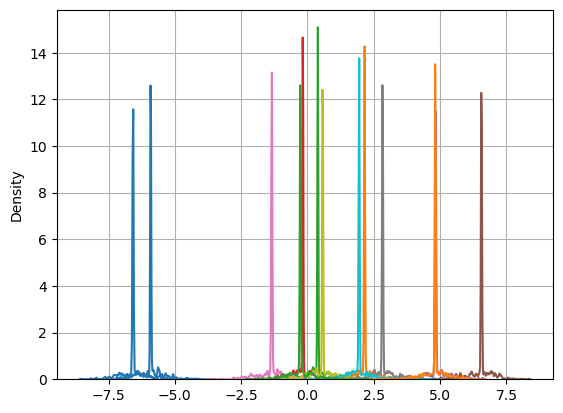

In [32]:
for k in range(thetas.shape[0]) :
    sns.kdeplot(thetas[k,:].detach().numpy(),bw_adjust=.2)
    plt.grid('on')

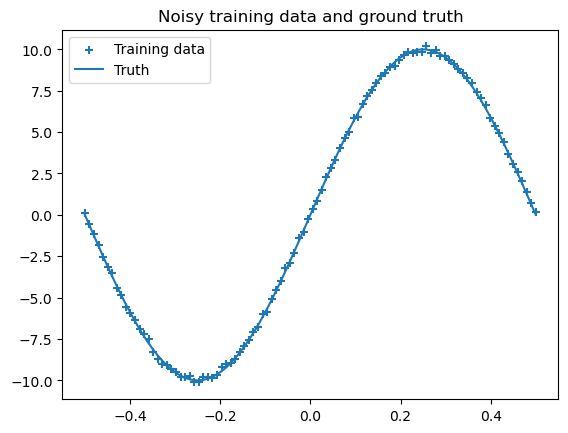

In [28]:
# Definition de la fonction de test
def f(x, sigma):
    epsilon = np.random.randn(*x.shape) * sigma
    return 10*np.sin(2*np.pi*x) + epsilon

# def f(x, sigma):
#     epsilon = np.random.randn(*x.shape) * sigma
#     return np.cos(x) + epsilon


# Paramétrage des données d'entrainements
train_size = 100
noise = 0.1
# Pour sin
xmin = -0.5
xmax = 0.5

# # Pour cos
# xmin = -3.5
# xmax = 3.5

X = np.linspace(xmin, xmax, train_size).reshape(-1, 1)
# X = np.linspace(-np.pi, np.pi, train_size).reshape(-1, 1)

y = f(X, sigma=noise)
y_true = f(X, sigma=0.0)


# On affiche tout ça
plt.scatter(X, y, marker='+', label='Training data')
plt.plot(X, y_true, label='Truth')
plt.title('Noisy training data and ground truth')
plt.legend()
plt.show()

XT = torch.Tensor(X).reshape(X.shape)
y = torch.Tensor(y).reshape(y.shape)
y_true = torch.Tensor(y_true).reshape(y_true.shape)

In [30]:
# Hypperparamètres
N = 1000
lmax = 200
P0 = 0.25
epsilon = 0.1
sigma_0 = 0.5
ns = [1, 2,2, 1]

# Notre modèle
myModel = BNN.FNN(ns)

# Temperature initiale
# T = np.sum(1 / np.log(2 + np.arange(lmax))) + 15
Temp = 40
TempMin = 15

# Distance qui va être utiliser pour évaluer
# la dissimilarité entre les prédictions y_hat et la réponse y
pdist = 2

# Ici on commence l'algorithm BNN-ABC-SS
NP0 = int(N*P0)
invP0 = int(1/P0)
myModelSize = BNN.modelSize(ns)

# On evalue tout ça
y_hats = torch.concat(
    tuple([myModel.update_weights(thetas[:, i]).forward(XT) for i in range(0, N)]), 1)

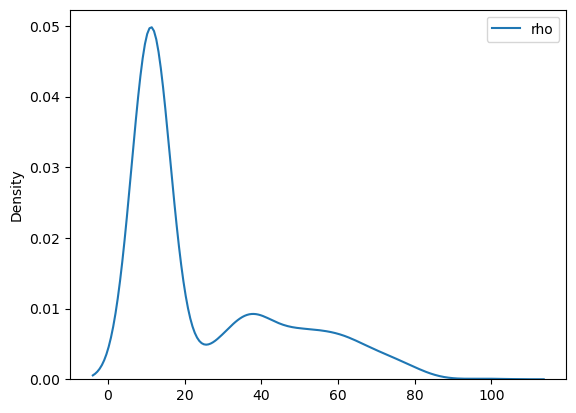

In [41]:
rho_n = torch.cdist(y_hats.t(), y.t(), p=pdist)

plt.figure()
sns.kdeplot(rho_n.detach().numpy(), label = 'rho')
plt.legend()
plt.show()

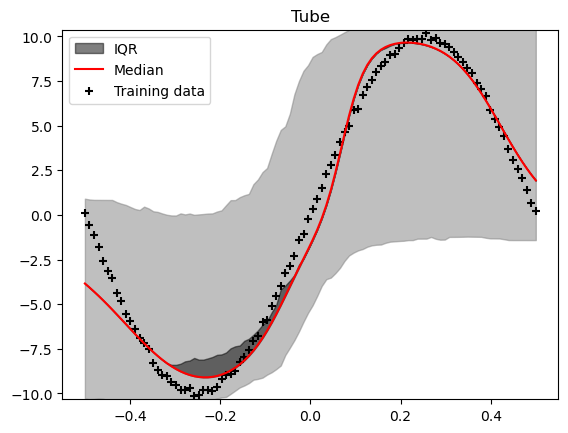

In [45]:
plt.figure()
BNN.plotTubeMedian(XT, y, thetas, ns)
plt.title("Tube")
plt.show()

In [64]:
hyperparameters = {"N" : N, "lmax" : lmax, "P0" : P0, "epsilon" : epsilon, "sigma_0" : sigma_0, "structure" : ns
                   ,"Temp" : Temp, "TempMin" : TempMin, "pdist" : pdist}
# save the figure
# datetime object containing current date and time
now = datetime.now()
# dd-mm-YY_H:M:S
dt_string = now.strftime("%d-%m-%Y_%H:%M:%S")
f = open('hyperparameters/h{}.txt'.format(dt_string), 'w')
f.close()
with open('hyperparameters/h{}.txt'.format(dt_string), 'w') as convert_file:
     convert_file.write(json.dumps(hyperparameters))

In [79]:
f = open("hyperparameters/h06-04-2023_14:15:49.txt",'r')
loadhyp = json.load(f)
f.close()

In [81]:
f = open('errors/er06-04-2023_14:27:14.txt', 'r')
loaderr = json.load(f)
f.close()

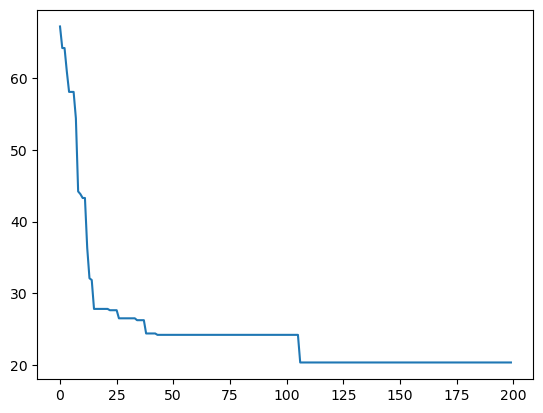

In [85]:
plt.plot(np.float32(loaderr["errorMin"]))